In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

show_head = False

In [2]:
gdf = gpd.read_file('/app/data/input/09CLBB_Predios_SII_Costanera')
gdf['Destino'] = gdf['Destino'].fillna('NO INFORMADO')
gdf['area_predio'] = gdf.area
if show_head: display(gdf.head(3))

In [3]:
grid = gpd.read_file('/app/data/input/grilla')
grid['area_grid'] = grid.area
if show_head: display(grid.head(3))

In [4]:
intersection = gpd.overlay(grid, gdf, how='intersection')
intersection['area'] = intersection.area
if show_head: display(intersection.head(3))

In [5]:
inter_cols = ['grid_id', 'Destino', 'area', 'area_grid', 'area_predio']
intersection = intersection[inter_cols]
if show_head: display(intersection.head(3))

In [6]:
total_inter_area = intersection.groupby(['grid_id'])['area'].agg('sum').reset_index().rename(columns={'area': 'inter_area'})
if show_head: display(total_inter_area.sort_values(by=['inter_area'], ascending=False).head(3))

In [7]:
intersection = pd.merge(intersection, total_inter_area, on='grid_id')
if show_head: display(intersection.head(3))

In [8]:
intersection['property_percentage'] = intersection['area']/intersection['inter_area']

In [9]:
intersection['information_per_property'] = -1*intersection['property_percentage']*np.log10(intersection['property_percentage'])
diversity = intersection.groupby('grid_id')['information_per_property'].agg('sum').reset_index()

In [10]:
diversity_map = pd.merge(diversity, grid, on='grid_id')
diversity_map.rename(columns={'information_per_property': 'diversity'}, inplace=True)

diversity_map = gpd.GeoDataFrame(data=diversity_map['diversity'], geometry=diversity_map['geometry'])

<Axes: >

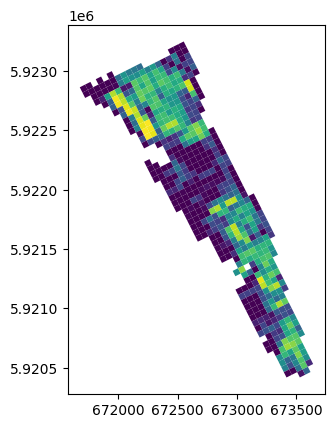

In [11]:
diversity_map.plot(column='diversity')

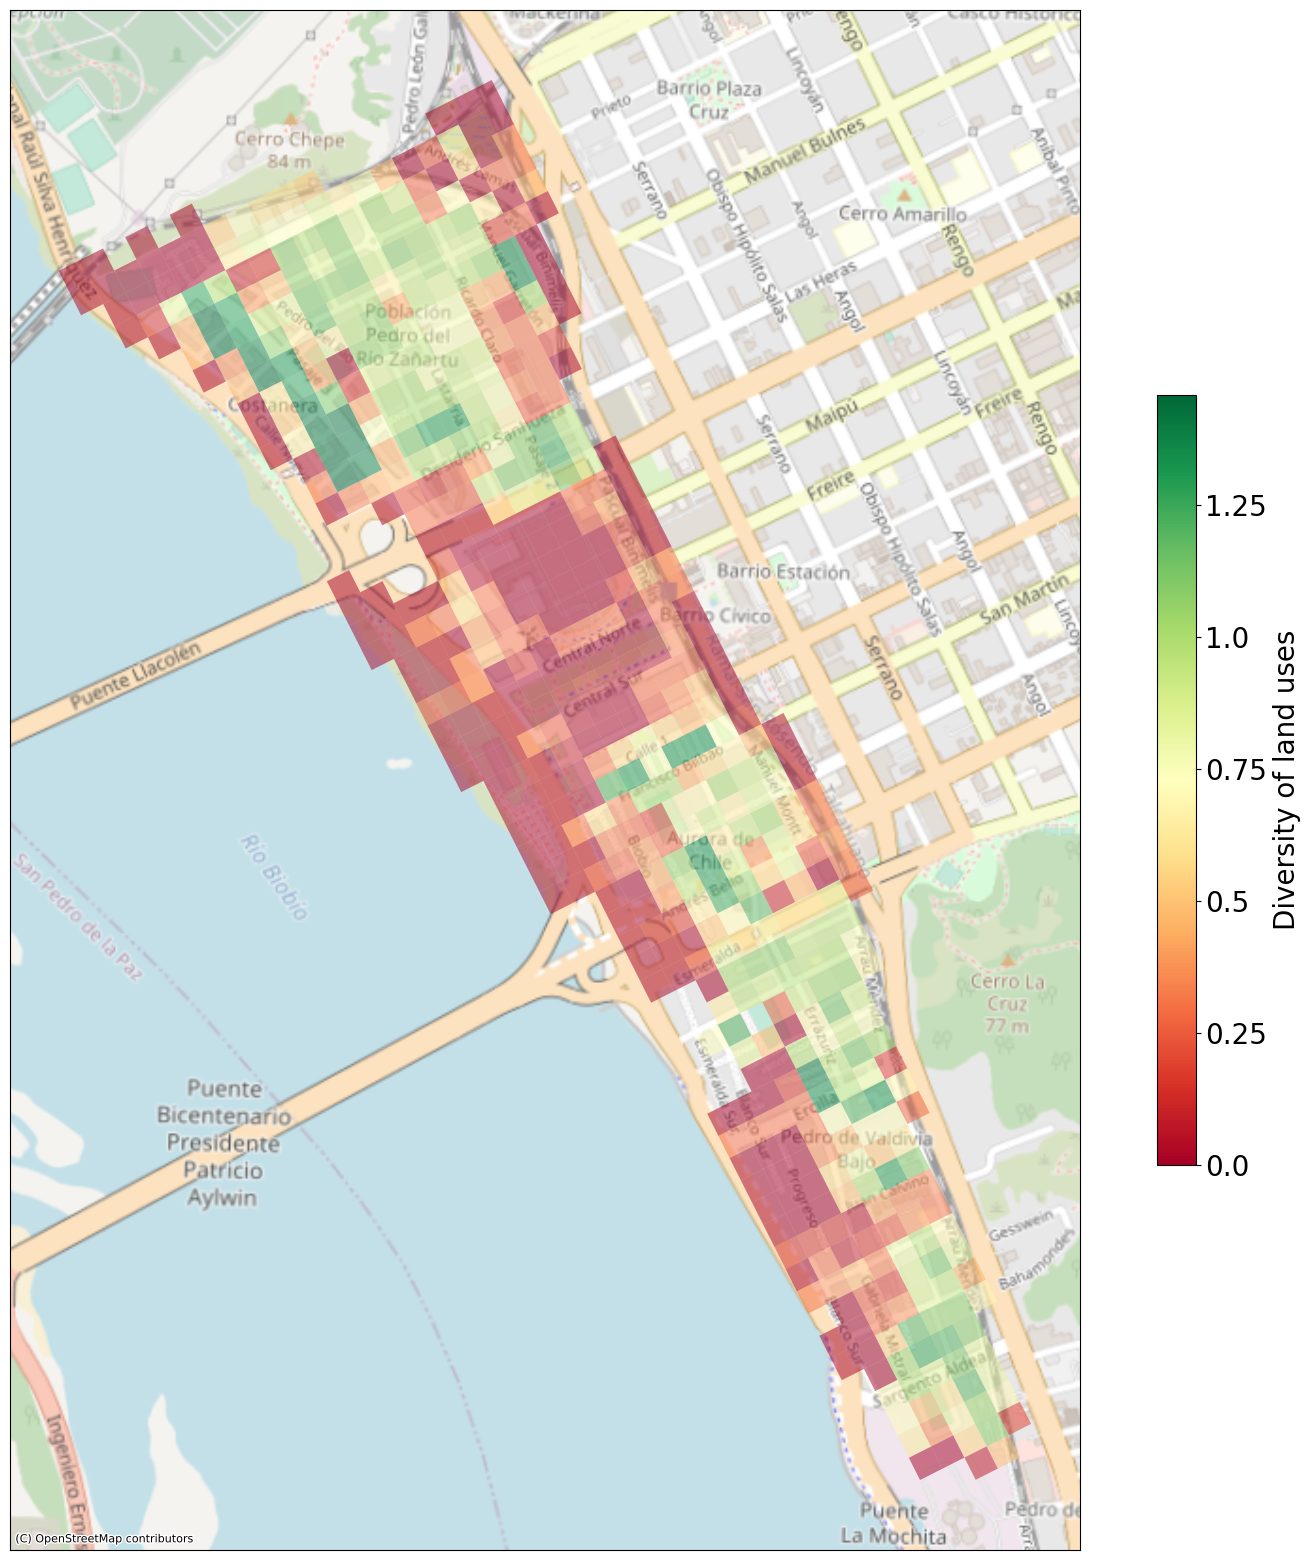

In [37]:
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import numpy as np  # Asegúrate de importar NumPy

(h, w) = (20, 20)
fig, ax = plt.subplots(figsize=(h, w))

# Rango deseado para la escala de colores
vmin = 0
vmax = diversity_map['diversity'].max()
cmap = 'RdYlGn'  # Utilizamos el colormap 'RdYlBu'

# Normalizar los valores de 'travel_time' para asegurar que estén dentro del rango de colores
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plotear las geometrías con los colores según 'travel_time'
diversity_map.plot(ax=ax, column='diversity', cmap=cmap, linewidth=0.8, edgecolor='none', norm=norm, alpha=0.5)

# Ajustar la escala de la barra de colores
cbar = fig.colorbar(mapper, ax=ax, shrink=0.5)
cbar.set_label('Diversity of land uses', size=20)  # Etiqueta de la barra de colores
ticks = np.arange(vmin, vmax, 0.25)
cbar.set_ticks(ticks)  # Puedes personalizar los ticks de la barra
str_ticks = [str(n) for n in ticks]
# str_ticks[-1] = f'{vmax:.1f}+'
cbar.set_ticklabels(str_ticks)  # Personalizar los valores de los ticks
cbar.ax.tick_params(labelsize=20)

# Agrega un mapa de fondo utilizando contextily
ctx.add_basemap(
    ax=ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=gdf.crs.to_string(),
    alpha=0.7
)

# plt.title(f'Diversidad de usos de suelos', size=30)
plt.xticks([])
plt.yticks([])
plt.savefig(f'/app/data/output/maps/diversity_land_uses.png', bbox_inches='tight', dpi=300)